In [1]:
import pandas as pd 
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

color = sns.color_palette()

In [2]:
df = pd.read_csv('../input/ecommerce-data/data.csv', encoding = 'ISO-8859-1')
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Cleaning and Feature Engineering

In [3]:
# check missing values for each column 
df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

In [4]:
# Remove missing rows
df.dropna(inplace=True)

##### Customer ID

In [5]:
df["CustomerID"] = df["CustomerID"].astype(int)

##### Invoice Date

In [6]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [7]:
df.insert(loc=2, column='year_month', value=df['InvoiceDate'].map(lambda x: 100*x.year + x.month))
df.insert(loc=3, column='month', value=df.InvoiceDate.dt.month)
df.insert(loc=4, column='day', value=(df.InvoiceDate.dt.dayofweek)+1)
df.insert(loc=5, column='hour', value=df.InvoiceDate.dt.hour)

##### InvoiceNo

In [8]:
df[df["InvoiceNo"].str.startswith("C") == True].head(1)

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,201012,12,3,9,Discount,-1,2010-12-01 09:41:00,27.5,14527,United Kingdom


In [9]:
df["Cancelled"] = df["InvoiceNo"].str.startswith("C")
df["Cancelled"] = df["Cancelled"].fillna(False)
df = df[df["Cancelled"] == False]
df.drop("Cancelled", axis=1, inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('int')

##### Description

In [10]:
'''
Utility function to plot Word Clouds
'''

def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(10,10), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
path = '../input/masks/masks-wordclouds/'

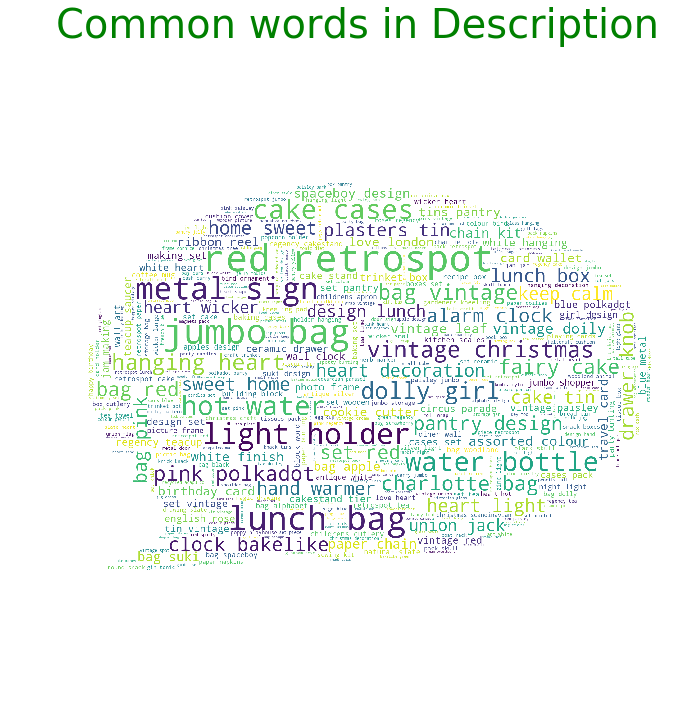

In [11]:
df['Description'] = df.Description.str.lower()
description = ' '.join(df['Description'])
description = str(description)
description_mask = np.array(Image.open(path + 'comment.png'))
plot_wordcloud(description, description_mask, max_words=400, max_font_size=120,title = 'Common words in Description')

In [12]:
df = df[df["Description"].str.startswith("?") == False]
df = df[df["Description"].str.contains("LOST") == False]

##### stockcode

In [13]:
df = df[(df["StockCode"] != "DOT") & (df["StockCode"] != "POST")]
df.drop("StockCode", inplace=True, axis=1)

##### Quantity

In [14]:
df = df[df['Quantity'] > 0]

#### Adding a column Total cost

In [18]:
df['TotalCost'] = df['Quantity'] * df['UnitPrice']

##### Country

In [ ]:
best_buyer = df.groupby(["Country", "InvoiceNo"])["TotalCost"].sum().reset_index().groupby(["Country"])["TotalCost"].mean().sort_values()
encoder_countries = best_buyer.rank().to_dict()
decoder_countries = {i: j for i, j in encoder_countries.items()}

df["Country"]  = df["Country"].apply(lambda x:encoder_countries[x])

# Exploratory Data Analysis (EDA)

### No of orders made by the customers

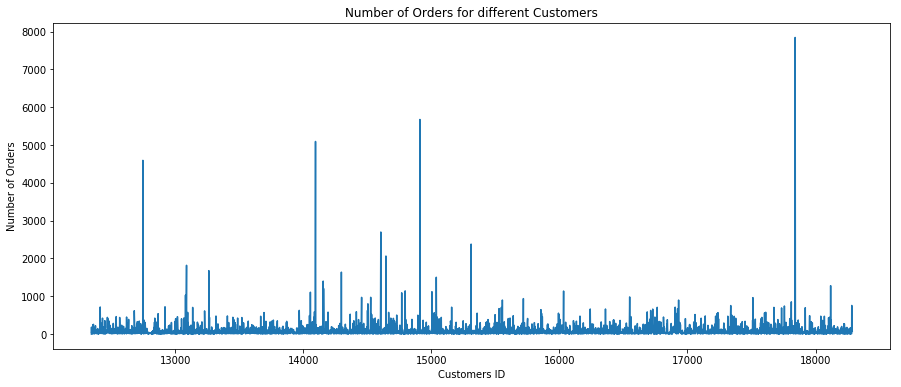

In [15]:
orders = df.groupby(by=['CustomerID','Country'], as_index=False)['InvoiceNo'].count()

plt.subplots(figsize=(15,6))
plt.plot(orders.CustomerID, orders.InvoiceNo)
plt.xlabel('Customers ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for different Customers')
plt.show()

#### TOP 5 Customers with most number of orders

In [16]:
orders.sort_values(by='InvoiceNo', ascending=False).head()

,CustomerID,Country,InvoiceNo
4019,17841,United Kingdom,7847
1888,14911,EIRE,5677
1298,14096,United Kingdom,5095
334,12748,United Kingdom,4595
1670,14606,United Kingdom,2699


### Amount spent by the customers

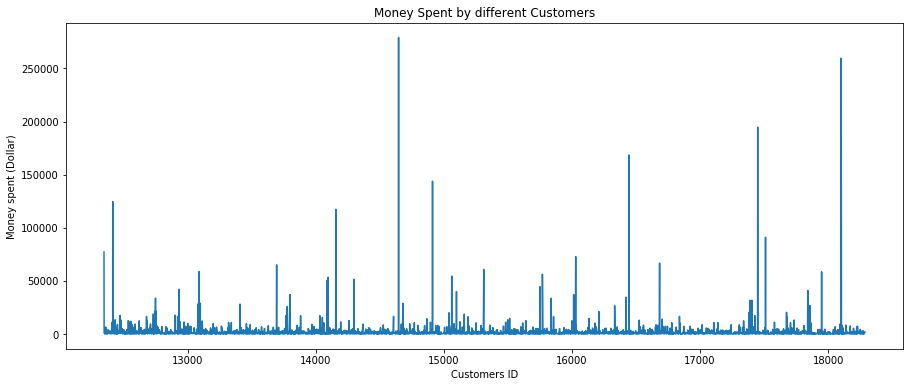

In [19]:
money_spent = df.groupby(by=['CustomerID','Country'], as_index=False)['TotalCost'].sum()

plt.subplots(figsize=(15,6))
plt.plot(money_spent.CustomerID, money_spent.TotalCost)
plt.xlabel('Customers ID')
plt.ylabel('Money spent (Dollar)')
plt.title('Money Spent by different Customers')
plt.show()

#### TOP 5 Customers with highest amount spent

In [20]:
money_spent.sort_values(by='TotalCost', ascending=False).head()

,CustomerID,Country,TotalCost
1698,14646,Netherlands,279138.02
4210,18102,United Kingdom,259657.30
3737,17450,United Kingdom,194550.79
3017,16446,United Kingdom,168472.50
1888,14911,EIRE,143825.06


### No of Orders per month

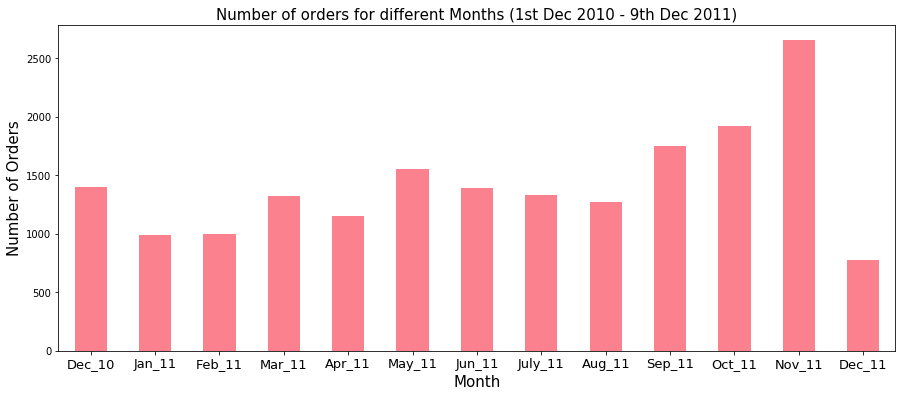

In [21]:
ax = df.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot('bar',color='#FC818E',figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
plt.show()

### No of orders per day

In [ ]:
ax = df.groupby('InvoiceNo')['day'].unique().value_counts().sort_index().plot('bar',color='#3FE2D8',figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

 ### No of Orders per hour


In [ ]:
ax = df.groupby('InvoiceNo')['hour'].unique().value_counts().iloc[:-1].sort_index().plot('bar',color='#FD702F',figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

In [ ]:
df.UnitPrice.describe()

**Some items have unit price = 0 (FREE items)**

There are some free items given to customers from time to time.

In [ ]:
plt.subplots(figsize=(12,6))
sns.boxplot(df.UnitPrice)
plt.show()

In [ ]:
df_free = df[df.UnitPrice == 0]

In [ ]:
ax = df_free.year_month.value_counts().sort_index().plot('bar',figsize=(12,6), color=color[0])
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_title('Frequency for different Months (Dec 2010 - Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11'), rotation='horizontal', fontsize=13)
plt.show()


- On average, the company gave out 2-4 times FREE items to customers each month (Except in June 2011)

### No of orders by country

In [ ]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)

layout = dict(title='Country wise Orders',
geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

### Countrywise Revenue

In [ ]:
revenue_per_country = df.groupby(["Country"])["TotalCost"].sum().sort_values()
country_names = list(revenue_per_country.index)
country_names = country_names[-10:]
country_names = country_names[::-1]
revenue_per_country = list(revenue_per_country)
revenue_per_country = revenue_per_country[-10:]
revenue_per_country = revenue_per_country[::-1]
plt.figure(figsize=(6,4))
sns.set_color_codes("pastel")
plt.title('Country Revenue', fontsize = 15)
sns.barplot(x= revenue_per_country, y= country_names,color = '#9370db');

### Best Buying Country

In [ ]:
best_buyer = df.groupby(["Country", "InvoiceNo"])["TotalCost"].sum().reset_index().groupby(["Country"])["TotalCost"].mean().sort_values()

country_names = list(best_buyer.index)
country_names = country_names[-10:]
country_names = country_names[::-1]
best_buyer = list(best_buyer)
best_buyer = best_buyer[-10:]
best_buyer = best_buyer[::-1]
plt.figure(figsize=(6,4))
sns.set_color_codes("pastel")
plt.title('Best Buying Country', fontsize = 15)
sns.barplot(x= best_buyer, y= country_names,color = '#FD702F');